In [2]:
import os
import pandas as pd

# تحديد المسارات الجديدة للبيانات
file_paths = [
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Morning.pcap_ISCX.csv",
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Monday-WorkingHours.pcap_ISCX.csv",
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Tuesday-WorkingHours.pcap_ISCX.csv",
    r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Wednesday-workingHours.pcap_ISCX.csv"
]

# تحميل البيانات
def load_data(file_paths):
    dataframes = []
    for path in file_paths:
        if os.path.exists(path):  # التأكد من أن الملف موجود
            print(f"Loading {path} ...")
            df = pd.read_csv(path, low_memory=False)
            df = df.sample(frac=0.1, random_state=42)  # تقليل حجم البيانات
            dataframes.append(df)
        else:
            print(f"File not found: {path}")

    if not dataframes:
        raise ValueError("No datasets were successfully loaded")
    
    return pd.concat(dataframes, ignore_index=True)

# تشغيل التحميل
df = load_data(file_paths)
print("Data loaded successfully!")
print(df.head())  # طباعة أول 5 صفوف للتأكد من نجاح التحميل

Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ...
Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Morning.pcap_ISCX.csv ...
Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Monday-WorkingHours.pcap_ISCX.csv ...
Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv ...
Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv ...
Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Tuesday-WorkingHours.pcap_ISCX.csv ...
Loading E:\Graduation-Project\NIDS\dataset\CICIDS2017\Wednesday-workingHours.pcap_ISCX.csv ...
Data loaded successfully!
    Destination Port   Flow Duration   Total Fwd Packets  \
0                 80         9392887                   4   
1              64007     

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from collections import Counter
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
class CICPreprocessor:
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.feature_columns = []

    def load_data(self):
        dataframes = []
        for path in self.file_paths:
            try:
                df = pd.read_csv(path, low_memory=False)
                # Sample 10% of the data to reduce memory usage
                df = df.sample(frac=0.1, random_state=42)
                dataframes.append(df)
            except Exception as e:
                print(f"Error loading file {path}: {e}")
        if not dataframes:
            raise ValueError("No datasets were successfully loaded")
        return pd.concat(dataframes, ignore_index=True)

    def optimize_data_types(self, df):
        for col in df.select_dtypes(include=['float64']).columns:
            df[col] = df[col].astype('float32')
        for col in df.select_dtypes(include=['int64']).columns:
            df[col] = df[col].astype('int32')
        return df

    def clean_column_names(self, df):
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        return df

    def remove_zero_columns(self, df):
        zero_columns = [col for col in df.columns if df[col].dtype in [np.int64, np.float64] and (df[col] == 0).all()]
        if zero_columns:
            df = df.drop(columns=zero_columns)
        return df

    def encode_labels(self, df):
        if 'label' in df.columns:
            le = LabelEncoder()
            df['label'] = le.fit_transform(df['label'].astype(str))
            self.label_encoders['label'] = le
        return df

    def handle_missing_values(self, df):
        df = df.replace([np.inf, -np.inf], np.nan)
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = self.imputer.fit_transform(df[numeric_cols])
        return df

    def remove_correlated_features(self, df, threshold=0.85):
        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        return df.drop(columns=to_drop)

    def select_important_features(self, X, y, n_features=20):
        selector = SelectKBest(score_func=f_classif, k=n_features)
        X_new = selector.fit_transform(X, y)
        self.feature_columns = X.columns[selector.get_support()].tolist()
        return pd.DataFrame(X_new, columns=self.feature_columns)

    def normalize_features(self, X_train, X_val, X_test):
        self.scaler.fit(X_train)
        X_train = pd.DataFrame(self.scaler.transform(X_train), columns=self.feature_columns)
        X_val = pd.DataFrame(self.scaler.transform(X_val), columns=self.feature_columns)
        X_test = pd.DataFrame(self.scaler.transform(X_test), columns=self.feature_columns)
        return X_train, X_val, X_test


    def handle_class_imbalance(self, X, y):
        print(f"Class distribution before SMOTE: {Counter(y)}")

        # Filter out classes with fewer samples than k_neighbors + 1
        min_samples = 6  # SMOTE's default k_neighbors is 5
        class_counts = Counter(y)
        valid_classes = [cls for cls, count in class_counts.items() if count >= min_samples]
        valid_indices = y.isin(valid_classes)

        X = X[valid_indices]
        y = y[valid_indices]

        smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

        return X_resampled, y_resampled


    def split_data(self, X, y):
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
        return X_train, X_val, X_test, y_train, y_val, y_test

    def reshape_data_for_cnn(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        samples, features = X.shape
        side_length = max(8, int(np.ceil(np.sqrt(features / 2))))  # Reduce side length to save memory
        padded_features = side_length ** 2
        padded_X = np.zeros((samples, padded_features))
        padded_X[:, :features] = X
        return padded_X.reshape(samples, side_length, side_length, 1)

    def build_cnn_model(self, input_shape, num_classes):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.25),
            Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.25),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.25),
            Flatten(),
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        optimizer = Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model


    def process(self):
        print("Starting preprocessing pipeline...")
        df = self.load_data()
        df = self.optimize_data_types(df)
        df = self.clean_column_names(df)
        df = self.remove_zero_columns(df)
        df = self.encode_labels(df)
        df = self.handle_missing_values(df)
        df = self.remove_correlated_features(df)

        X = df.drop('label', axis=1)
        y = df['label']

        print("Selecting important features...")
        X = self.select_important_features(X, y)

        print("Handling class imbalance...")
        X, y = self.handle_class_imbalance(X, y)

        print("Splitting data...")
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)

        print("Normalizing features...")
        X_train, X_val, X_test = self.normalize_features(X_train, X_val, X_test)

        print("Reshaping data for CNN...")
        X_train_reshaped = self.reshape_data_for_cnn(X_train)
        X_val_reshaped = self.reshape_data_for_cnn(X_val)
        X_test_reshaped = self.reshape_data_for_cnn(X_test)

        print("Converting labels to categorical format...")
        y_train_categorical = to_categorical(y_train)
        y_val_categorical = to_categorical(y_val)
        y_test_categorical = to_categorical(y_test)

        print("Building CNN model...")
        input_shape = X_train_reshaped.shape[1:]
        num_classes = y_train_categorical.shape[1]
        cnn_model = self.build_cnn_model(input_shape, num_classes)

        print("Setting up callbacks...")
        early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

        print("Training CNN model...")
        history = cnn_model.fit(
            X_train_reshaped, y_train_categorical,
            validation_data=(X_val_reshaped, y_val_categorical),
            epochs=50,  # Increased epochs to allow early stopping to determine optimal point
            batch_size=64,  # Increased batch size for better training stability
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )

        print("Evaluating CNN model...")
        test_loss, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_test_categorical)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        return cnn_model, X_test_reshaped, y_test_categorical,history

In [5]:
file_paths = [
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",  
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",  
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Friday-WorkingHours-Morning.pcap_ISCX.csv",  
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Monday-WorkingHours.pcap_ISCX.csv",
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Tuesday-WorkingHours.pcap_ISCX.csv",
     r"E:\Graduation-Project\NIDS\dataset\CICIDS2017\Wednesday-workingHours.pcap_ISCX.csv"
] 

preprocessor = CICPreprocessor(file_paths)
cnn_model, X_test_reshaped, y_test_categorical, history = preprocessor.process()

print("Making predictions on test set...")
predictions = cnn_model.predict(X_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test_categorical, axis=1)

Starting preprocessing pipeline...
Selecting important features...


c:\Users\Shahd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [17 19 29 30 31 32 33 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Shahd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Handling class imbalance...
Class distribution before SMOTE: Counter({0.0: 227282, 4.0: 23051, 10.0: 15889, 2.0: 12917, 3.0: 1002, 7.0: 799, 11.0: 599, 6.0: 558, 5.0: 555, 1.0: 181, 12.0: 166, 14.0: 66, 9.0: 4, 13.0: 3, 8.0: 2})
Class distribution after SMOTE: Counter({2.0: 227282, 0.0: 227282, 10.0: 227282, 1.0: 227282, 12.0: 227282, 14.0: 227282, 11.0: 227282, 7.0: 227282, 4.0: 227282, 5.0: 227282, 3.0: 227282, 6.0: 227282})
Splitting data...
Normalizing features...
Reshaping data for CNN...
Converting labels to categorical format...
Building CNN model...


c:\Users\Shahd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Setting up callbacks...
Training CNN model...
Epoch 1/50
29831/29831 ━━━━━━━━━━━━━━━━━━━━ 267s 9ms/step - accuracy: 0.8132 - loss: 0.4992 - val_accuracy: 0.8881 - val_loss: 0.2095 - learning_rate: 1.0000e-04
Epoch 2/50
29831/29831 ━━━━━━━━━━━━━━━━━━━━ 313s 10ms/step - accuracy: 0.8983 - loss: 0.2202 - val_accuracy: 0.9106 - val_loss: 0.1819 - learning_rate: 1.0000e-04
Epoch 3/50
29831/29831 ━━━━━━━━━━━━━━━━━━━━ 330s 11ms/step - accuracy: 0.9083 - loss: 0.1963 - val_accuracy: 0.9118 - val_loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 4/50
29831/29831 ━━━━━━━━━━━━━━━━━━━━ 325s 11ms/step - accuracy: 0.9135 - loss: 0.1860 - val_accuracy: 0.9212 - val_loss: 0.1677 - learning_rate: 1.0000e-04
Epoch 5/50
29831/29831 ━━━━━━━━━━━━━━━━━━━━ 269s 9ms/step - accuracy: 0.9165 - loss: 0.1798 - val_accuracy: 0.9346 - val_loss: 0.1607 - learning_rate: 1.0000e-04
Epoch 6/50
29831/29831 ━━━━━━━━━━━━━━━━━━━━ 269s 9ms/step - accuracy: 0.9201 - loss: 0.1748 - val_accuracy: 0.9323 - val_loss: 0.1562 - learn

Making predictions on test set...
12785/12785 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
Classification Report with Original Labels:
                          precision    recall  f1-score   support

                  BENIGN       1.00      0.95      0.97     34092
                     Bot       0.99      1.00      1.00     34092
                    DDoS       0.99      1.00      0.99     34092
           DoS GoldenEye       1.00      0.99      0.99     34093
                DoS Hulk       0.98      1.00      0.99     34093
        DoS Slowhttptest       1.00      0.99      0.99     34093
           DoS slowloris       0.98      1.00      0.99     34092
             FTP-Patator       1.00      1.00      1.00     34093
                PortScan       0.99      1.00      0.99     34092
             SSH-Patator       1.00      1.00      1.00     34092
Web Attack � Brute Force       0.84      0.61      0.71     34092
        Web Attack � XSS       0.69      0.88      0.78     34092

                

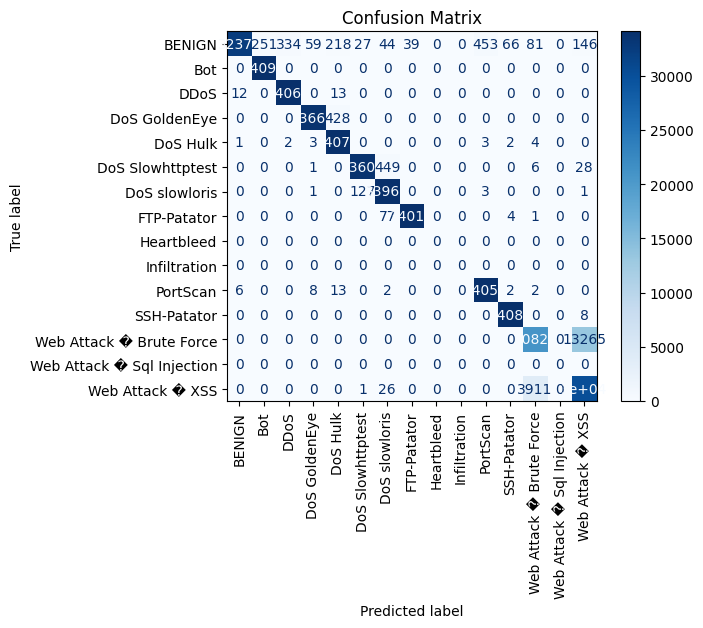

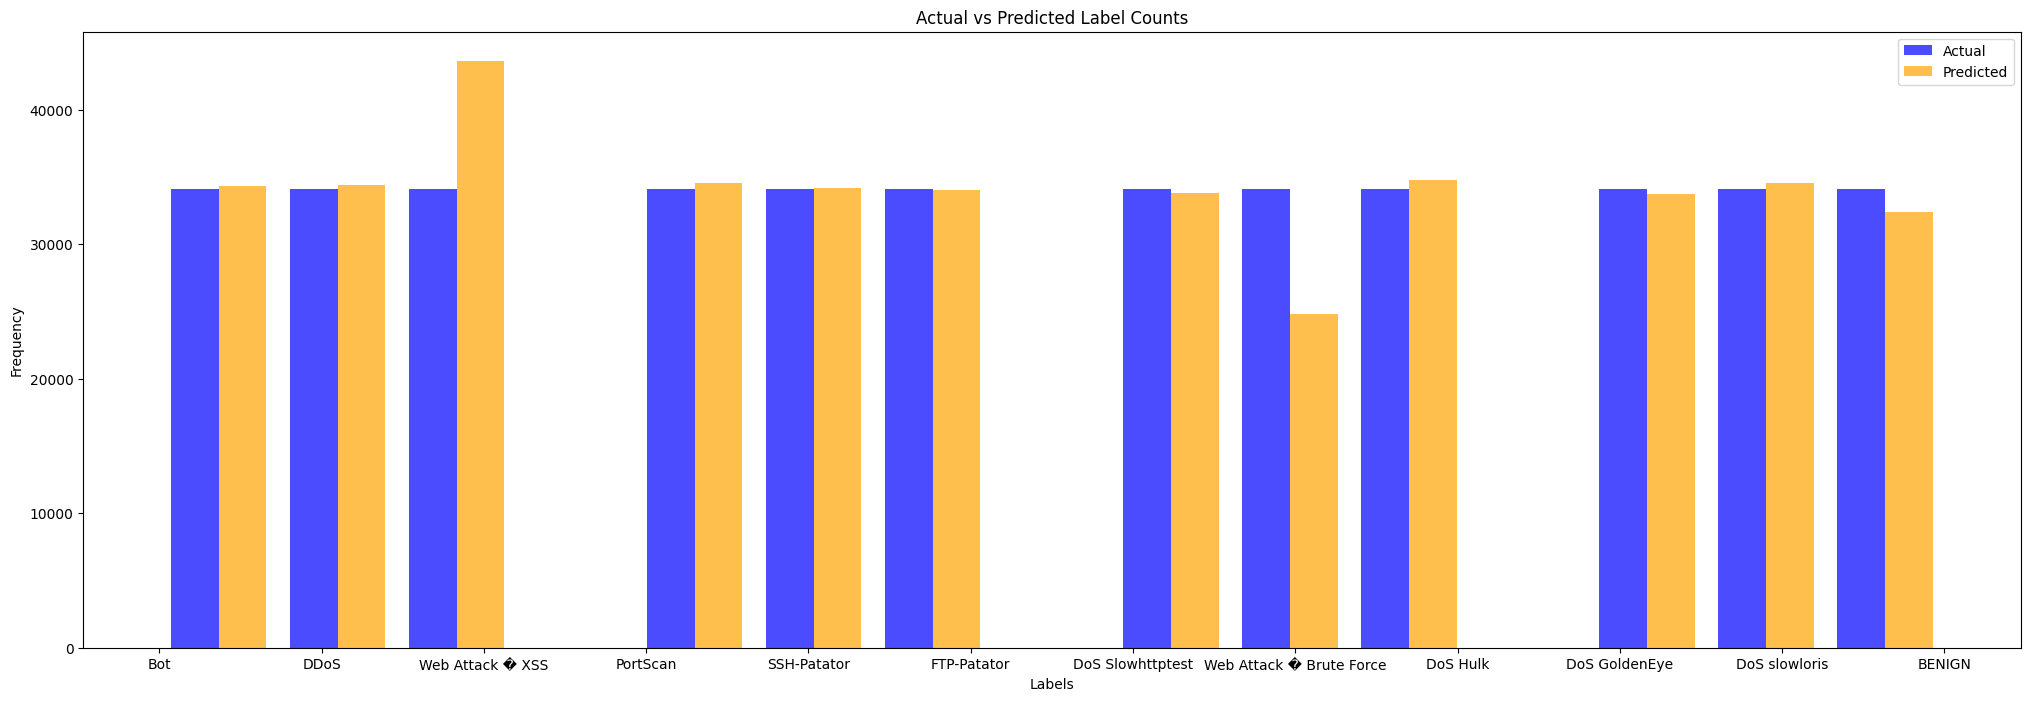

In [6]:
print("Making predictions on test set...")
predictions = cnn_model.predict(X_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test_categorical, axis=1)

# Decode original labels
label_encoder = preprocessor.label_encoders['label']
original_predicted_classes = label_encoder.inverse_transform(predicted_classes)
original_actual_classes = label_encoder.inverse_transform(actual_classes)

# Classification Report
print("Classification Report with Original Labels:")
print(classification_report(original_actual_classes, original_predicted_classes))

# Confusion Matrix
cm = confusion_matrix(original_actual_classes, original_predicted_classes, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Plot Actual vs Predicted Counts
plt.figure(figsize=(25, 8))
plt.hist([original_actual_classes, original_predicted_classes], bins=len(label_encoder.classes_), label=['Actual', 'Predicted'], color=['blue', 'orange'], alpha=0.7)
plt.title("Actual vs Predicted Label Counts")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.legend()
plt.show()

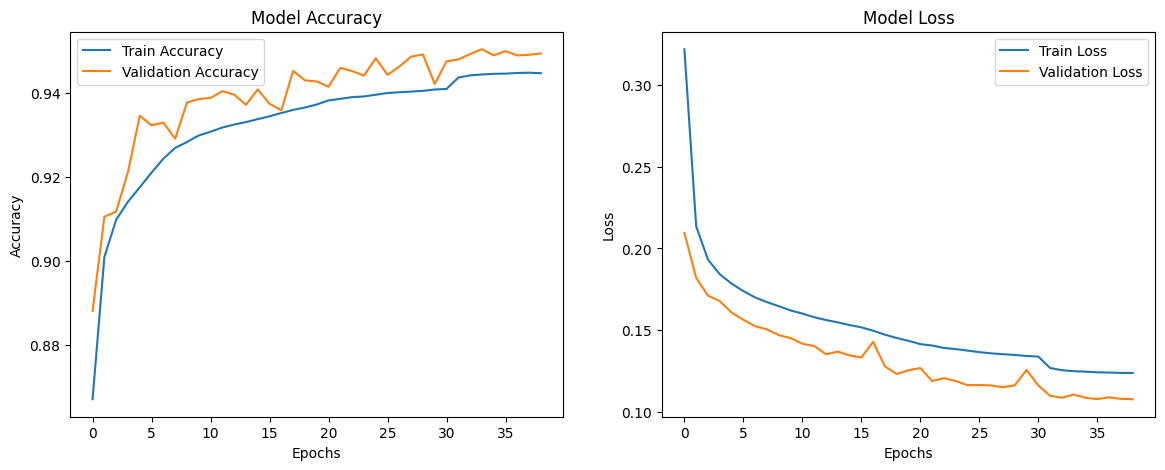

In [7]:
# Plot accuracy and loss curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()